<h1 style="color:#239B56;">Robo-Advisor</h1>

## Overview:

We want to generate an unusually "safe" portfolio. Rather than maximize returns, we want to keep returns as close as possible to zero. In other words, the goal is to generate a portfolio, based on a random set of tickers, whose projected value over an arbitrary number of days is as close to its starting value as possible.

Table of contents:

_____________________________________________________________________________

0.0 Imports

0.1 Global Variables

1. DATA CLEANING

    1.1 Read in CSV and Create Functions

    1.2 Filter Data (ETL and QA)

2. CHOOSING THE STOCKS

    2.1 Percent Returns DataFrame

    2.2 The Point System

3. CREATING THE OPTIMAL PORTFOLIO

    3.1 Stock Betas

    3.2 Monte Carlo Simulation

    3.3 Final Portfolio

4. ANALYSIS AND SANITY / CORRECTNESS CHECKS

    4.1 Value and Weights Check

    4.2 Expected Returns Visualization

    4.3 Returns Check (With Market Comparison)

    4.4 Graphed Returns Check With Additional Data (With Market Comparison)

5.1 Output Final Information to .CSV File

5.2 Conclusion

5.3 Sources

_____________________________________________________________________________

Data cleaning involves removing tickers that do not fit certain criteria (which is chosen by the user).

Choosing the stocks means picking the tickers which we will utilize in our final portfolio.

Creating the portfolio involves implementing a Monte Carlo simulation to generate random portfolios and collect the expected return of each. The final portfolio will be that which has the expected return closest to 0. We will calculate expected return based on a <b>Multi-Security Capital Asset Pricing Model (MSCAPM)</b> (below).

![MSCAPM](Pricing-Model-Image.jpg)

The code should output the final portfolio and share count to a .csv file.

Analysis and sanity checks involve visual representations to enhance comprehension, ensuring that the value of the portfolio is correct, as well as showing that the portfolio is indeed expected to return close to 0% over a given period of time, among other characteristics.

Objective assumptions:

- Fractional shares can be purchased
- There will be no transaction costs when buying stocks.
- Once the portfolio is set, it cannot be changed.
- Dividends will be ignored

## Why MSCAPM?

The Multi-Security Capital Asset Pricing Model (MSCAPM for short) gives the expected return for an asset relational to its risk with the market.

One of the primary assumptions we make when deriving the desired portfolio is that <b>systematic risk will drive the majority of price volatility.</b> There are two reasons for this:

1. Since we encourage the user to choose a large number of stocks to put in the portfolio, the portfolio will likely be diversified. This means there will be a lower probability of a high correlation between the securities we select, or volatility based on certain idiosyncratic events.

2. We have implemented measures to try and lower the correlation between securities in the portfolio.

With this assumption in mind, we decided that the MSCAPM was the best pricing model to use for two main reasons:

1. CAPM is a tested and proven model

2. Including beta as a factor allows us to imply both correlation and risk (volatility) into one variable, and will bias the allocation of capital towards stocks that have lower volatility (and therefore a lower beta)

Some issues with other viable methods:

1. Picking the portfolio with the lowest volatility
- Doesn't consider correlation strongly. With this model, it's possible for the correlation between securities to be high, which could cause portfolio value movements to trend in one direction over time, despite the low volatility.

2. Picking the portfolio with the lowest expected return (by combining the weighted returns for each security)
- Doesn't consider volatility heavily. The magnitude of volatility may be strong.
- With the MSCAPM model, we can calculate an expected return while also considering volatility, the risk-free rate, and market activity.

#### 0.0 Imports

In [21]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta

import threading
from queue import Queue
import random
from random import uniform

import os
import sys

### 0.1 Global Variables

In [22]:
#.csv file of tickers.
csv_file = "Example-of-Tickers.csv"

#Variables for filtering.
minimumMonthlyTradingDays = 20 #For a valid month in volume calculation
minimum_volume = 200_000 #Monthly, for valid months.
required_denomination = 'USD'

#Maximum number of stocks allowed in the portfolio.
max_tickers = 25

#REFERENCE DATA - CHANGE BASED UPON INVESTMENT HORIZON
#    Dates for data references made when looking at statistics like volatility, correlation, and beta.
start = '2022-08-01'
end = '2022-12-20'

#Reference market for beta calculations, returns visualization.
ref_market = "^NYA"
market_name = "NYSE"

capital = 500_000 #How much money we have to spend.
price_date = '2022-12-20' #Date of purchase for stocks.
estimated_rf = .0383 #Fill in with estimated risk-free rate for the investment horizon.

#Lowest and highest percentage of any given security in the portfolio.
#Integers. Will be converted to decimals (%).
lowest_weight = 1
highest_weight = 20

numdays = 5 #For expected return (NUMBER OF TRADING DAYS ONLY).

## 1. DATA CLEANING: 

The following cells are where the data cleaning happens.

THE GOAL:

• Ignore any tickers that do not reference a valid stock denominated in USD, i.e., we want to only use US-listed stocks.

• Only use tickers that reference stocks with an average monthly volume of at least 200,000 shares, as calculated based on a specified time interval. A month is defined as a calendar month. We will drop any month that does not have at least 20 trading days.

THE PROCESS:

Firstly, we have chosen to implement multithreading, to speed up the process. The data cleaning code is the most time-consuming code in the program to run (Due to the time it takes to send a request to the yfinance API). Because of this, we have two main functions (currency_check and volume_check), running on two separate threads, c and v. These functions are defined recursively; If too many tickers are passed into the function (i.e a list of tickers that is longer than 'max_length_lst' in each function), the function calls on several threads to run the function with smaller, sub-lists. When a small enough quantity of tickers is passed to the function, it will perform the criteria check for the tickers. Valid tickers get passed to the function's respective queue. Finally, the queue is cleared, and tickers that fit both criteria are outputted and saved as our tickers.

Note 1: Currency check generates more threads per application than volume_check because it takes significantly longer to run. This is also why its 'max_list_length' variable is smaller.

Note 2: For the sake of comparison, when tested by our team:

- Unthreaded, non-recursive code takes ~13 minutes to run.
- Multithreaded, non-recursive code takes ~5-10 minutes to run.
- <b>Multithreaded, recursive code takes ~1 minute to run.</b>

Note 3: 'max_length_lst' may need to be updated for larger lists of tickers.

Note 4: Duplicates will be filtered out.

Our code checks each of the two criteria mentioned in the goal (one for each function) and generates two lists. Each list contains tickers that reference stocks that have satisfied the requirements of the functions. As we want stocks that fit both criteria, our final list of (valid) tickers is the set intersection of the two lists which each function produces.

#### 1.1 Read in CSV and Create Functions

In [23]:
# Make values into a list
tickers = pd.read_csv(csv_file)
ticker_list = tickers.iloc[:, 0].values.tolist()
ticker_list.insert(0, tickers.columns[0])

In [24]:
#Consumes desired amount of trading days within a month, a DataFrame of daily information, a DataFrame 
#of monthly information, and a list of months that corresponds to the months on the DataFrame, outputs the monthly 
#DataFrame with only months that have 'daycount' amount of trading days for that stock.
#   Note: Function will cover up to the last date. For example, the function will not produce October for a DataFrame which ends on October 1st.
#      In our code, we simply passed a days DataFrame that ends one month after the months DataFrame does (^).
def df_with_valid_months(daycount, df_days, df_months, months):
    for month in range (len(months)):
        if len(df_days.filter(like = months[month], axis = 0)) < daycount:
            df_months.drop(df_months.index[month], axis = 0, inplace = True) #Drop any months with not enough trading days.
            
    return(df_months)

#Consumes historical data for a stock, outputs average volume.
def average_volume(df_hist):
    volume = df_hist['Volume'].dropna().values.tolist()
    vol_av = np.mean(volume)

    return(vol_av)


#### 1.2 Filter Data (ETL and QA)

In [25]:
#dates for volume calculation.
vol_date_s = '2021-01-01'
vol_date_e = '2022-11-02' #Must be YYYY-MM-02.

#end date for valid months function (see (^)).
endDForValidMonthsFunct = str((pd.to_datetime(vol_date_e) + relativedelta(months = 1)).strftime("%Y-%m-%d"))

#for df_with_valid_months function, creates a series of months from vol_date_s to vol_date_e.
months = pd.date_range(vol_date_s, vol_date_e, freq='MS').strftime("%Y-%m").tolist()

#Here we will put valid stocks that fit our criteria.
tickers = []

currency_valid = []
volume_valid = []

#Queue variables to store tickers.
queueC = Queue()
queueV = Queue()

#Performs a simple check to check for invalid tickers. Returns valid tickers (Those that are listed and have information on yfinance).
def invalid_check(tickers, checkDateS, checkDateE):
    #get dates for history.
    ticker_val = []

    for ticker in tickers:
        try:
            #Check, gives an error if ticker is invalid / delisted. We check in this manner so that yfinance doesn't show
            #multiple console outputs for each ticker that is invalid (When passed through volume and currency checks).
            check = yf.Ticker(ticker).history(start = checkDateS, end = checkDateE).iloc[0,0]

            #Add valid ticker to list.
            ticker_val.append(ticker)
        except:
            pass
    
    return(ticker_val)

#Consumes a list of strings that represent tickers and the required denomination, checks if the tickers are denominated in 'required_denomination'.
#    Requires: All strings that represent tickers passed in ticker_list are valid.
def currency_check(ticker_list, required_denomination):
    max_length_lst = 5

    #When there are an appropriate number of tickers in ticker_list, the function performs the currency check.
    if len(ticker_list) <= max_length_lst:

        #Retrieve financial currency from each ticker. If it is 'required_denomination', it is a valid ticker. Else, we don't care so we set it as nan.
        for ticker in ticker_list:
            tick = yf.Ticker(ticker)
            currency = tick.info['currency']
        
            #Check criteria, add to list of valid tickers for currency.
            if currency == required_denomination:
                #Pass our valid tickers to the QueueC (Queue Currency), so that they may be called on later.
                queueC.put(ticker)

    #If there are too many tickers in ticker_lst, we run a recursive application of currency_check with 
    #numthreads threads, with the arguments being one of numthreads equal parts of ticker_list.
    else:
        numthreads = 5

        ticker_split = np.array_split(ticker_list, numthreads)

        # Start numthreads threads, add to list.
        threads = []
        for n in range(numthreads):
            cSub = threading.Thread(target = currency_check, args = (ticker_split[n], required_denomination,))
            cSub.start()
            threads.append(cSub)

        # Wait for threads to finish.
        for t in threads:
            t.join()
 
#Consumes a list of tickers, the start and end date for the volume check, the proper end date (as specified at ^), the minimum number of trading days for a
#valid month, and the minimum required average volume. Used to check if the tickers have an average monthly volume of 'minimum_volume' or more for months
#with 'minimumMonthlyTradingDays' or more trading days.
def volume_check(ticker_list, vol_start, vol_end, proper_end, min_days, minimum_volume):
    max_length_lst = 10
    
    #When there are an appropriate number of tickers in ticker_list, the function performs the volume check.
    if len(ticker_list) <= max_length_lst:

        #Retrieve monthly average volume from each ticker. If it is greater than or equal to minimum_volume, it is a valid ticker. Else, we ignore it.
        for ticker in ticker_list:
            tick = yf.Ticker(ticker)
            
            #Create history for volume check.
            tick_hist = tick.history(start = vol_start, end  = vol_end, interval = '1mo').dropna()

            #Custom DataFrame for valid months check (daily, ending one month after monthly DataFrame ends).
            tickHistForValidMonthsCheck = tick.history(start = vol_start, end  = proper_end, interval = '1d').dropna()
 
            #Dataframe with valid months only.
            tickHistWithValidMonths = df_with_valid_months(min_days, tickHistForValidMonthsCheck, tick_hist, months)

            #Call on average_volume function to compute an average volume.
            monthly_average_volume = 0 #Initialize this to 0 to prevent errors.
            monthly_average_volume = average_volume(tickHistWithValidMonths)

            #Check criteria, add to list of valid tickers for volume.
            if monthly_average_volume >= minimum_volume:
                #Pass our valid tickers to the QueueV (Queue Volume), so that they may be called on later.
                queueV.put(ticker)

    #If there are too many tickers in ticker_lst, we run a recursive application of volume_check with numthreads threads, with the arguments being one of
    #numthreads equal parts of ticker_list.
    else:
        numthreads = 2

        ticker_split = np.array_split(ticker_list, numthreads)

        # Start numthreads threads, add to list.
        threads = []
        for n in range(numthreads):
            vSub = threading.Thread(target = volume_check, args = (ticker_split[n], vol_start, vol_end, proper_end, min_days, minimum_volume))
            vSub.start()
            threads.append(vSub)

        # Wait for all threads to finish.
        for t in threads:
            t.join()

ticker_list = [*set(ticker_list)]#Remove duplicates.

#Get only valid tickers
ticker_list = invalid_check(ticker_list, vol_date_s, vol_date_e)

#Creating threads for currency_check and volume_check function.
c = threading.Thread(target = currency_check, args = (ticker_list, required_denomination,))
v = threading.Thread(target = volume_check, args = (ticker_list, vol_date_s, vol_date_e, endDForValidMonthsFunct, minimumMonthlyTradingDays, minimum_volume))

#Start thread executions.
c.start()
v.start()

#Wait for v to finish, grab all elements from queue.
v.join()
while not queueV.empty():
    volume_valid.append(queueV.get())

#Wait for c to finish, grab all elements from queue.
c.join()
while not queueC.empty():
    currency_valid.append(queueC.get())

#Valid tickers are the intersection of the two lists (Must have particular denomination and average monthly volume).
tickers = sorted([value for value in currency_valid if value in volume_valid])

print(f"\nValid Tickers: {tickers}")

Got error from yahoo api for ticker QQQQQ, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- QQQQQ: No timezone found, symbol may be delisted
PCLN: No data found for this date range, symbol may be delisted
Got error from yahoo api for ticker RTN, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- RTN: No timezone found, symbol may be delisted

Valid Tickers: ['AAPL', 'ABBV', 'ABT', 'ACN', 'AIG', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'C', 'CAT', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'GM', 'GOOG', 'JPM', 'KMI', 'KO', 'LLY', 'LMT', 'MNSO', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'SBUX', 'SHOP', 'SLB', 'SNOW', 'SO', 'SPG', 'T', 'UNP', 'UPS', 'USB']


## 2. CHOOSING THE STOCKS:

The following cells are where we choose the stocks to be used for the final portfolio.

THE GOAL:

Since our overall goal is to have a portfolio that finishes as close to its starting value as possible, we naturally want a diversified and stable selection of stocks. With this in mind, we decided to use a system which considers correlation and volatility (the explanation for this system is a few cells down).

Essentially, we want:

• (if there are less than max_tickers tickers to choose from) Every (valid) ticker available <b>OR</b>
  (if there are more than max_tickers tickers to choose from) 'max_tickers' tickers, comprised of:

• The stocks who earn the most "points" in our point system.

• Note: Volatility, as we define it in this section, is represented by the standard deviation of daily returns:

\begin{align*}
\sigma_X=\sqrt{\frac{\sum(x_i-\overline{X})^2}{N}}
\end{align*}

- Where $x_i$ are individual returns of some security $X$, $N$ is the total number of observations (time periods for us)

• Note: Correlation, as we define it in this section, is as follows:

 \begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

Where COV(X,Y) is: 

\begin{align*}
COV(X,Y)=\frac{\sum(x_i-\overline{X})\times(y_i-\overline{Y})}{N}
\end{align*}

THE PROCESS:

We will obtain closing data for each ticker, and calculate returns. Then, we will use our point system to select the tickers that will be conducive to our goal.

#### 2.1 Percent Returns DataFrame

The code below takes in a list of valid tickers and returns 2 DataFrames -- one containing the tickers and their closing prices, and one containing the tickers and their respective percent returns. 

We iterate through the list of tickers and retrieve the closing prices of each stock from Yahoo Finance. The tickers serve as keys in the dictionary where the values are lists of tickers' corresponding closing prices. This dictionary is then converted to a DataFrame – the DataFrame of closing prices.

We then create a second dictionary where the keys are the tickers in the ticker list, and implement the 'pct_change' function on closing prices for each stock, yielding percent returns, which serve as the keys. This dictionary is converted into a second DataFrame - the DataFrame of percent returns.

In [26]:
#Creates a DataFrame of closing prices from start_date to end_date for ticker_list.
def get_closing_df(ticker_list, start_date, end_date):
    interval = '1d'

    #dictionary of closing prices.
    closing_dict = {}
    #.history is not inclusive of end date, so we add one day.
    end_date =str((pd.to_datetime(end_date) + relativedelta(days = 1)).strftime("%Y-%m-%d"))

    #Fills closing_dict dictionary with closing prices for each ticker in closing_tickers.
    for ticker in ticker_list:
        tick = yf.Ticker(ticker)
        tick_hist = tick.history(start = start_date, end = end_date, interval = interval)

        closing_dict[ticker] = tick_hist['Close']

    closing_df = pd.DataFrame(closing_dict)

    return(closing_df) 

#Creates a DataFrame of percent returns from start_date to end_date for a DataFrame of closing prices.
def get_returns_from_close_df(closing_df):
    #Dictionary of returns.
    returns = {}

    #Fills returns dictionary with the pct returns for each ticker in closing_df.
    for price in closing_df:
        returns[price] = closing_df[price].pct_change()

    returns_df = pd.DataFrame(returns)

    return(returns_df)

#We will use these for analysis.
tickers_closeDF = get_closing_df(tickers, start, end) 
tickers_returnDF = get_returns_from_close_df(tickers_closeDF)

#print("Closing Prices Preview:")
#tickers_closeDF.head()

print("Percent Returns Preview:")
tickers_returnDF.head()

Percent Returns Preview:


,AAPL,ABBV,ABT,ACN,AIG,AMZN,AXP,BA,BAC,BIIB,...,SBUX,SHOP,SLB,SNOW,SO,SPG,T,UNP,UPS,USB
Date,,,,,,,,,,,,,,,,,,,,,
2022-08-01 00:00:00-04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-02 00:00:00-04:00,-0.009287,0.001212,-0.008035,-0.007416,-0.006466,-0.009085,-0.011283,-0.034246,-0.019875,-0.000526,...,-0.014133,0.035675,0.007967,0.015830,-0.009781,-0.028997,-0.019754,-0.020169,-0.009266,-0.012208
2022-08-03 00:00:00-04:00,0.038248,0.005770,0.008929,0.018811,0.017156,0.039952,0.025264,0.020578,0.018160,0.021277,...,0.042528,0.111023,-0.031344,0.058682,0.017516,0.013747,0.000545,0.014067,-0.000568,0.015555
2022-08-04 00:00:00-04:00,-0.001926,-0.016147,0.001004,0.007918,-0.008918,0.021861,0.009265,-0.000840,-0.007134,0.017322,...,-0.004469,-0.021703,-0.044738,-0.009916,0.009190,-0.010381,-0.005444,0.007623,0.005687,-0.012379
2022-08-05 00:00:00-04:00,-0.002774,-0.006335,-0.004284,-0.004056,0.013889,-0.012415,0.004080,-0.008769,0.016766,0.004142,...,-0.013237,-0.005119,0.020913,0.029672,-0.008978,0.006426,0.004379,0.005586,0.011515,0.006798


#### 2.2 The Point System

The following code uses a volatility metric and a correlation metric to generate the tickers which will use in our final portfolio. Here's how it works:

1. The <i><b>standard deviation of each stock's percent returns (daily)</i></b> will be used as the <b>volatility</b> metric.
- The least volatile stocks will receive the most points, the most volatile stock will receive 0 points.

2. The <i><b>correlation of the daily % returns of each stock</i></b> with the <i><b>average of the daily % returns of every stock in the portfolio combined</i></b> will be used as the <b>correlation</b> metric.
- The stocks that are either most or least correlated with the portfolio (i.e correlation metric is closest to -1 or 1) will receive the most points (as many points as the least volatile stock), and the points will converge to 0 (with the stock in the middle receiving 0 points (or 1 point if the number of tickers is even))

- Note: We decided to do this because it is more likely that we will achieve our goal if we use tickers that correlate negatively with each other. (i.e those that correlate positively with the portfolio are highly likely to correlate negatively with those who correlate negatively with the portfolio, hence creating a balance)

3. The "score" of each ticker is calculated by:

 \begin{align*}
S= (Pv(i))(Wv) + (Pc(i))(Wc) 
\end{align*}

Where:
- Pv(i) is the points earned for volatility for stock i
- Wv is the weight of importance for volatility (Wv = 1 is recommended based on trials conducted by team)
- Pc(i) is the points earned for correlation for stock i
- Wc is the weight of importance for correlation (Wc = 1 is recommended based on trials conducted by team)

4. A "weight of importance" is simply a number that multiplies each element in the set of scores. The user of the program may choose the ratio of importance for the volatility metric vs the correlation metric. A 1:1 volatility to correlation ratio (Implying that volatility is equally as important as correlation) is recommended by our team based on test-runs of this program, but the user may choose any ratio.
- Note: There are more complicated systems which could possibly select a better set of tickers (such as taking into account the specific values for volatility and correlation as opposed to simply ranking them on a linear scale), but for the sake of this program, we have chosen not to implement such systems as it is beyond our scope of expertise. In any case, our system selects tickers that will be conducive to a balanced, diversified portfolio with little price-change inertia.

We then sort the scores of each ticker in descending order, and pick the first 'max_tickers' number of tickers (those with the highest score). We use this final list of the tickers to filter our existing close prices and percent return DataFrames such that each only has values for each ticker in our list, and store these as new DataFrames.

- Note: The score difference across placings for either volatility or correlation is linerar (i.e if 1st place has 5 more points than 6th place, 6th place has 5 more points than 11th place)

In [27]:
#Importance ratios.
weight_volatility = 1
weight_correlation = 1

#Calculates volatility for each ticker in pr_df (percent returns DataFrame) (standard deviation of daily percent return).
def get_volatility(pr_df):
    all_stock_vol = []

    # Performs the calculations for every column.
    for pctchange in range(len(pr_df.columns)):
        # Calculates the standard deviation of the stock's daily percent return.
        stock_vol = pr_df.iloc[:,pctchange].std()
        all_stock_vol.append(stock_vol)

    return(all_stock_vol)

#Calculates correlation for each ticker in tickers to every ticker in tickers (from start to end date).
def get_correlation(tickers, start, end):
    #List for correlations.
    correlations = []

    #Get a DataFrame with percent returns for each ticker.
    #     We had to create a new one rather than simply passing the existing due to issues with Pandas.
    closedf = get_closing_df(tickers, start, end)
    corr_df = get_returns_from_close_df(closedf)

    #Copy of correlation DataFrame to use later to call on values.
    corr_df_orig = corr_df.copy()

    #Grab the average percent return across all tickers for each day present in corr_df.
    port = []
    for date in corr_df.index:
        port.append(sum(corr_df.loc[date,:]) / len(corr_df.columns))

    #Initialize corr_df to only have one column (using above calculated values).
    corr_df['portfolio'] = port
    corr_df = corr_df[['portfolio']]

    #Get daily returns of ticker, calculate the correlation with above.
    for ticker in tickers:
        tick = yf.Ticker(ticker)
        corr_df.loc[:, 'ticker'] = corr_df_orig.loc[:,ticker].values

        #Grab correlation from correlation matrix.
        correlations.append(corr_df.corr().iloc[0,1])

    return(correlations)

#Grab the values for volatility and correlation.
tick_vol = get_volatility(tickers_returnDF)
tick_corr = get_correlation(tickers, start, end)

#Sort tickers based on volatility and correlation respectively, create new lists.
vol_tix = [x for _, x in sorted(zip(tick_vol, tickers))]
corr_tix = [x for _, x in sorted(zip(tick_corr, tickers))]

#Ceiling for scores.
num_nums = len(vol_tix)

#Volatility scores.
#   The ticker with the lowest volatility will receive the most points, and the points decrease for each more volatile ticker.
vol_scores = list(reversed(list(range(0, num_nums))))

#Correlation scores.
#   The highest points are awarded to the tickers on either extreme (close to -1 or 1), and points converge to the middle (lowest points).
#   2 Cases because we need to know whether to add a score of 0 (for the middle score of an odd number of tickers).
#   Range is the number of tickers // 2, with every value multiplied by 2.
if num_nums % 2 == 0:
    corr_scores_right = list(map(lambda s: s * 2, list(range(0, num_nums // 2))))
    corr_scores_left = list(map(lambda s: s * 2, list(reversed(list(range(0, num_nums // 2))))))
else:
    corr_scores_right = list(map(lambda s: s * 2, list(range(1, num_nums // 2 + 1))))
    corr_scores_left = list(map(lambda s: s * 2, list(reversed(list(range(1, num_nums // 2 + 1))))))
    corr_scores_left.append(0)

#Add left and right score sets to ensure they converge to 0.
corr_scores = corr_scores_left + corr_scores_right

#Account for the importance ratios.
vol_scores = [score * weight_volatility for score in vol_scores]
corr_scores = [score * weight_correlation for score in corr_scores]

#DataFrame of each ticker and their scores for volatility and correlation (#).
scores = pd.concat([pd.Series(vol_scores, index = vol_tix), pd.Series(corr_scores, index = corr_tix)], keys=['VOL', 'CORR'], axis = 1)

#Create a sum of the scores for each row, adjust the DataFrame.
score = scores.sum(axis = 1)
scores['SCORE'] = score
scores.sort_values(by = 'SCORE', ascending = False, inplace = True)

#Show volatility, correlation, and overall scores, sorted by overall score.
print(f"Scores:\n {scores}")

scores.reset_index(inplace = True)

#If the amount of tickers is greater than max tickers, grab the first 'max_tickers' tickers to use in final portfolio, else use all of them.
if len(scores.index) > max_tickers:
    ticklist_final = scores.iloc[0 : max_tickers, 0].values.tolist()
else:
    ticklist_final = scores.iloc[:, 0].values.tolist()

#Get percent returns DataFrame and price DataFrame.
tickersReturn_final = tickers_returnDF[ticklist_final]
tickersPrice_final = tickers_closeDF[ticklist_final]

print(f"\nStocks in Portfolio ({len(ticklist_final)}): \n{ticklist_final}")

Scores:
        VOL  CORR  SCORE
MON     54    54    108
MRK     49    48     97
BMY     45    52     97
LMT     41    44     85
LLY     37    46     83
MO      48    34     82
AIG     38    42     80
MS      25    54     79
C       26    52     78
ABBV    46    32     78
AXP     24    50     74
PFE     43    28     71
CL      52    18     70
PEP     50    20     70
KO      53    16     69
JPM     29    40     69
CSCO    39    28     67
ACN     19    48     67
T       42    24     66
MSFT    17    44     61
BAC     23    38     61
SO      44    16     60
BLK     12    46     58
CVS     31    26     57
PG      51     4     55
BK      27    26     53
PM      47     6     53
MNSO     0    50     50
AAPL    16    34     50
COP     13    36     49
ABT     40     8     48
OXY      6    42     48
UPS     28    20     48
GM      14    32     46
USB     33    12     45
QCOM     9    36     45
CMCSA   22    22     44
ORCL    30    14     44
SPG     20    24     44
BIIB     3    40     43
SLB    

## 3. CREATING THE OPTIMAL PORTFOLIO:

The following cells are where we generate the portfolio whose expected return is as close to 0 as possible.

THE GOAL:

We want to use the MSCAPM to determine which allocation of capital yields the lowest absolute expected return.

THE PROCESS:

Since we want to use the MSCAPM as the basis for judgement, we first gather a set of custom betas, one for each ticker (based on an allocated period of historical data). We opt to not use the benchmark 5-year beta provided by Yahoo Finance, as it is not available for all tickers, and the custom beta may be changed to bias more recent or a broader range of market activity. We then implement multithreading* to efficiently generate one million portfolios in a Monte-Carlo simulation, each with a random allocation of capital (weight) to each security. We save the MSCAPM score** (expected return) of each weighting, as well as the best CAPM score and the weights associated with it. Finally, we generate a portfolio using a specified amount of capital, with each security being weighted according to the "optimal weights" (those that yield the lowest absolute MSCAPM score).

*Multithreading is, in theory, not the most efficient method. We will get into that soon.

**We use a modified MSCAPM score to gather scores for the Monte Carlo (Explained a couple cells down)

#### 3.1 Stock Betas

Our portfolio_beta function takes in the new percent returns DataFrame, the ticker used to represent the market, and the start and end date of the data being collected for the market stock (we use the same dates used to collect data for the tickers in the final portfolio).

The function first creates a DataFrame storing the percent returns of the market stock and merges this DataFrame with the DataFrame containing the percent returns of the stocks to be used in the final portfolio.

A matrix is then generated using the merged DataFrame, containing the beta of every stock in relation to another stock in the DataFrame. The beta value of each stock relative to the market is then stored in a new DataFrame which is returned with each index (ticker) lining up with the respective beta value. Beta is calculated as follows:

Consider Security $X$ with returns given by $x_i$, and let the corresponding market returns be $r_M$.  Beta is then given by:

\begin{align*}
\beta=\frac{COV(x_i,r_M)}{\sigma^2(r_M)}
\end{align*}

Finally, we store the beta values in a list that can be called later.

We decided to use the NYSE (New York Stock Exchange) as our reference market here, as we believe it to be the most all-encompassing market (since it has a diverse set of stocks, as well as the most stocks). We assume that all tickers passed are US-listed, but the market which we are taking beta relative to can be changed if that is not the case, or if factors want to be considered (such as a list of only S&P 500 tickers).

In [28]:
#Consumes a DataFrame of the percent returns of stocks and a stock to represent the "market". It then returns the beta of each stock in the DataFrame
#compared to the "market" inputted. The "market" stock must be a string of how the ticker appears in yfinance.
def portfolio_beta(pr_df, market_stock, start, end):

    # Creates a DataFrame of the percent returns of the stock representing the market.
    market = yf.Ticker(market_stock)
    market_close = market.history(start = start, end = end, interval = "1d")['Close']
    market_pr = market_close.pct_change()
    market_pr_df = pd.DataFrame({market_stock: market_pr})
    
    # Merges pr_df and the market_pr_df together and drops the first row which is NaN values because there is no percent return for the first data point.
    beta_data = pr_df.merge(market_pr_df, left_index = True, right_index= True)
    beta_data.drop(index = beta_data.index[0], inplace = True)

    #Calculates the variance of the stock representing the market.
    MarketVar = market_pr_df[market_stock].var()
    #Creates the beta matrix of the merged DataFrame.
    Beta_matrix = beta_data.cov()/MarketVar

    #Prints Beta Matrix.
    #print("Portfolio's Beta Matrix Preview:")
    #print(Beta_matrix.head())

    #DataFrame of the Betas of each stock.
    portfolio_stock_beta = pd.DataFrame({"Beta": Beta_matrix.iloc[:, (len(Beta_matrix) - 2)],})
    portfolio_stock_beta.drop(market_stock, inplace = True)
    
    return(portfolio_stock_beta)

portfolio_betas = portfolio_beta(tickersReturn_final, ref_market, start, end)
beta_list = portfolio_betas['Beta'].values.tolist()

#Prints the Beta of each stock.
print("Portfolio's Stocks' Betas Preview:")
portfolio_betas.head()

Portfolio's Stocks' Betas Preview:


,Beta
MON,-0.010219
MRK,0.365519
BMY,0.334163
LMT,0.459397
LLY,0.420102


#### 3.2 Monte Carlo Simulation

Now that we have beta values for each ticker, we begin the process of finding the optimal portfolio. As previously mentioned, we will be using multithreading to generate one million portfolios, each with each security weighted randomly (but within the restraints defined by the user at the start of the program). 

First, we find the market's expected return (By gathering returns from samples of a given number of days defined by the user for a set of prices and taking the mean), as well as the risk-free rate (by multiplying the daily risk-free rate by the number of days defined by the user), both for the period which we want to calculate the portfolio's expected return. 

We calculate the MSCAPM score without using the risk-free rate, as it was causing issues with the program. This was happening for reasons beyond our comprehension. Note that the risk-free rate only scales the expected return up linearly for each expected return, so its absence does not affect the performance of the simulation. The new formula is as follows:

\begin{align*}
\sum_{i = 1}^{n}W_i\times \beta _i\times M
\end{align*}

We take note of the lowest MSCAPM score* and the weights associated with it, and generate a portfolio (the <b>optimal</b> portfolio). The value of this portfolio can then be tracked over time. 

* We grab the lowest score from our modified calculation, and then use its components to generate the expected return based on the original MSCAPM formula.

Note: In the code,

rm = market expected return, and

rf = risk-free rate


Reminder of MSCAPM calculation:

![MSCAPM](Pricing-Model-Image.jpg)

In [29]:
#Retrieves the closing prices of a list of tickers on a specific date.
def get_prices(ticker_list, price_date):
    #Set end date to one day after target date (.history is non-inclusive of end date).
    end_date = str((pd.to_datetime(price_date) + relativedelta(days = 1)).strftime("%Y-%m-%d"))
    prices = []
    interval = '1d'

    #Retrieve price from each ticker and store it in a list.
    for ticker in ticker_list:
        tick = yf.Ticker(ticker)
        price = tick.history(start = price_date, end = end_date, interval = interval)['Close'][0]
        prices.append(price)

    #Return list of prices.
    return(prices)

#Generates a list of N numbers, summing to k, between max and min.
#    Note: The distribution will be biased towards the mean (k / n). This function must be run many times to achieve values on each extreme, 
#          depending on variables passed.
def weight_generation(N, k, min, max): # *
    assert(N * min <= k <= N * max)
    adjusted_k = k - min * N
    while True:
        endpoints = sorted(uniform(0, adjusted_k) for i in range(N - 1))
        values = [*(end - begin + min
                    for begin, end in zip([0] + endpoints,
                                          endpoints + [adjusted_k]))]
        if all(v <= max for v in values):
            return (values)

#Consumes a list of daily returns and a number of days, returns the expected return for numdays amount of days.
def expectedReturnXDays(prices_list, numdays):
    #We are only interested in every 'numdays' amount of days.
    prices_list = prices_list[::numdays]

    #Get expected return.
    exReturn = np.mean([a1 / a2 - 1 for a1, a2 in zip(prices_list[1:], prices_list)])

    return(exReturn)


In [30]:
#Number of iterations for Monte-Carlo.
num_hypothetical_portfolios = 1000000

#Risk free rate adjusted.
rf = estimated_rf / 365 * numdays

#Initializing queue for weights function, and list to store values.
global queueW
queueW = Queue()
queueWGetter = []

#Initialize optimal weighting list to prevent errors.
optimal_weighting = []

#Generates 'num_ports' random weightings for a portfolio holding stocks in 'ticker_list'. Uses MSCAPM to generate ticker weights which will yield the
#expected return which is closest to zero when combined in a portfolio.
def best_weighting(market_prices_list, ticker_list, beta_list, num_ports, lowest_weight, highest_weight, numdays):

   #Initial sanity check
   if (highest_weight * len(ticker_list) < 100) or (lowest_weight * len(ticker_list) > 100):
      sys.exit("Error generating portfolio. Check weights and try again.")

   best_weights = []
   best_mscapm_score = 10000 #Initialize to high number so that first portfolio's score will replace it.
   mscapm_scores = []

   #Get market expected returns.
   rm = expectedReturnXDays(market_prices_list, numdays)

   #for each index, i in set_information, i[0] will hold the best MSCAPM score, i[1] will hold the weights that yield that score, i[2] holds all mscapm scores.
   set_information = []

   #If there are an appropriate number of portfolios to be generated, function will perform weighting check.
   if num_ports <= 100000:

      #Generate random weights, scale back.
      for i in range (0, num_ports):
         weights = weight_generation(len(ticker_list), 100, lowest_weight, highest_weight)
         weights = [(x / 100) for x in weights]

         #Generate modified MSCAPM score, add to list.
         mscapm = 0

         for m in range(len(weights)):
            mscapm += weights[m] * beta_list[m] * rm #Summarized / modified version of MSCAPM (no RF).
            
         mscapm_scores.append(mscapm)

         #Check for best MSCAPM score (closest to 0).
         if abs(mscapm) < best_mscapm_score:
            best_mscapm_score = mscapm
            best_weights = weights

      set_information.append(best_mscapm_score) 
      set_information.append(best_weights)
      set_information.append(mscapm_scores)

      #Puts set information into queueW to be retrieved later.
      queueW.put(set_information)

   #If there are too many portfolios to be generated, function creates numthreads threads, each generating num_ports // numthreads portfolios.
   else:
      numthreads = 10

      num_ports_new = num_ports // numthreads

      # Start numthreads threads.
      threads = []
      for n in range(numthreads):
         wSub = threading.Thread(target = best_weighting, args = (market_prices_list, ticker_list, beta_list, num_ports_new, lowest_weight, highest_weight, numdays,))
         wSub.start()
         threads.append(wSub)

      # Wait for all threads to finish.
      for t in threads:
         t.join()

#Creates a portfolio with columns Ticker (ticker), Price (price as of price_date), Shares (shares to be bought based on capital and weight),
#Value (price * shares), and Weights (weight of each stock).
#Requires: index of weights match up with index of columns (i.e stock y in column x has weight z in index x).
def create_weighted_portfolio(weights, price_df, capital, price_date):
   shares = []
   value = []
   #Index of final portfolio begins at 1.
   index = list(range(1, (len(weights) + 1)))

   #Closing price of each stock on price_date.
   prices = get_prices(price_df.columns, price_date)

   #Calculating shares, value of stock in portfolio.
   for i in range (0, len(weights)):
      shares.append((capital * weights[i]) / prices[i])
      value.append(prices[i] * shares[i])

   #Dictionary.
   portfolio_final_dict = {'Ticker': price_df.columns,
                        'Price ($)': prices,
                        'Shares': shares,
                        'Value ($)': value,
                        'Weight': weights}
 
   portfolio = pd.DataFrame(portfolio_final_dict)
   portfolio.index = index

   return(portfolio)
   
#Grab list of market prices.
market_prices_list = get_closing_df([ref_market], start, end)[ref_market].values.tolist()

#Runs best_weighting.
run_weights = threading.Thread(target = best_weighting, args = (market_prices_list, ticklist_final, beta_list, num_hypothetical_portfolios, lowest_weight, highest_weight, numdays,))
run_weights.start()
run_weights.join()

#Grab information from queueW.
while not queueW.empty():
   queueWGetter.append(queueW.get())

#We need to find the best score from the best scored of each threads. These calculations are similar to those found in the best_weighting function.

#Initialize variables.
best_score = 10000 #High so that any given collection of stocks will beat it.
mscapm_scores = []

#Gets information for MSCAPM scores, grabs best score, and optimal weights.
for set_info in range (0, len(queueWGetter)):
   mscapm_scores.append(queueWGetter[set_info][2])

   #Check for best score.
   if abs(queueWGetter[set_info][0]) < best_score:
      best_score = queueWGetter[set_info][0]
      optimal_weighting = queueWGetter[set_info][1]

#mscapm_scores is a list of lists, so we make it flat.
mscapm_scores = [item for sublist in mscapm_scores for item in sublist]

#rm for below calculation.
rm = expectedReturnXDays(market_prices_list, numdays) 
#Calculate actual expected return for optimal portfolio.
port_expected_return = 0
for m in range(len(ticklist_final)):
   port_expected_return += optimal_weighting[m] * (rf + beta_list[m] * (rm - rf))#This is equivalent to the summation notation form.

#Percent return over numdays days.
port_expected_return = best_score * 100
Portfolio_Final = create_weighted_portfolio(optimal_weighting, tickersPrice_final, capital, price_date)

#### 3.3 Final Portfolio

In [31]:
#Create a final portfolio with rounded values to show to the user. Here we simply grab values from the Portfolio_Final DataFrame and round them. Since
#we want Portfolio_Final to be exact, we cannot just round its values.
portfolio_final_show_dict = {'Ticker': Portfolio_Final.loc[:, 'Ticker'].values.tolist(),
                        'Price ($)': np.round(Portfolio_Final.loc[:, 'Price ($)'].values.tolist(), 2),
                        'Shares': np.round(Portfolio_Final.loc[:, 'Shares'].values.tolist(), 2),
                        'Value ($)': np.round(Portfolio_Final.loc[:, 'Value ($)'].values.tolist(), 2),
                        'Weight (%)': np.round([x * 100 for x in Portfolio_Final.loc[:, 'Weight'].values.tolist()], 2)}

#Make DataFrame, set index.
portfolio_final_show = pd.DataFrame(portfolio_final_show_dict)
index = list(range(1, (len(ticklist_final) + 1)))
portfolio_final_show.index = index

#Final portfolio.
portfolio_final_show

,Ticker,Price ($),Shares,Value ($),Weight (%)
1,MON,10.20,8407.12,85715.66,17.14
2,MRK,109.71,394.13,43239.53,8.65
3,BMY,72.65,630.04,45772.11,9.15
4,LMT,486.15,40.61,19742.89,3.95
5,LLY,359.64,54.17,19482.91,3.90
6,MO,45.50,307.98,14013.12,2.80
7,AIG,62.80,106.39,6681.49,1.34
8,MS,85.16,254.71,21691.19,4.34
9,C,43.81,132.46,5803.09,1.16
10,ABBV,160.58,142.45,22875.06,4.58


## 4. ANALYSIS AND SANITY / CORRECTNESS CHECKS:

The following cells are where we perform checks to ensure the portfolio is correctly sized and weighted, as well as show visual representations of why this is the optimal portfolio for our goal.

THE GOAL:

- Ensure the total value of the portfolio is how much capital we allocated to it
- Ensure the weights of our stocks add up to 100%
- Visually represent the expected return of our portfolio, its performance, and explain why the portfolio is optimal

THE PROCESS:

We first calculate a simple sum of the value of each security in our portfolio, and a sum of the weights, and ensure they add up to the amount of capital we put into the portfolio, and 100% respectively.

Then, we plot the expected returns of a sample of weighted portfolios, as well as the optimal portfolio on a line graph. We mark the optimal portfolio with a star.

Next, we provide a "performance check", where we can input two days (start and end) and track the returns of our portfolio, compared to a given market, and the expected return of our portfolio.

Finally, we graph the returns of our portfolio, the returns of the market, the average return of our portfolio and the market, and the expected return of our portfolio. We hope to show conclusive evidence that our portfolio not only outperforms the market in terms of (lower) volatility but also achieves our desired outcome. We will analyze this graph, and make conclusions.


#### 4.1 Value and Weights Check

In [32]:
try:
    #Total value and weight of portfolio.
    val = int(np.round(sum(Portfolio_Final['Value ($)'], 0)))
    weight = np.round(sum(Portfolio_Final['Weight'], 0))

    print(f"Total Portfolio Value:  ${val}")
    print(f"Total Portfolio Weight: {weight * 100}%")

    #Print message depending on whether or not portfolio values are correct.
    if val == capital and weight == 1:
        print("\nEverything is correct!")
    else:
        print("\nWeight or Total Value is incorrect.")
except:
    print("Something went wrong when trying to calculate the value and weight of your portfolio.")


Total Portfolio Value:  $500000
Total Portfolio Weight: 100.0%

Everything is correct!


#### 4.2 Expected Returns Visualization

The fact that there exists significant variance between the expected returns of differently weighted portfolios shows that our analysis and process for selecting the optimal portfolio is important. (see below)

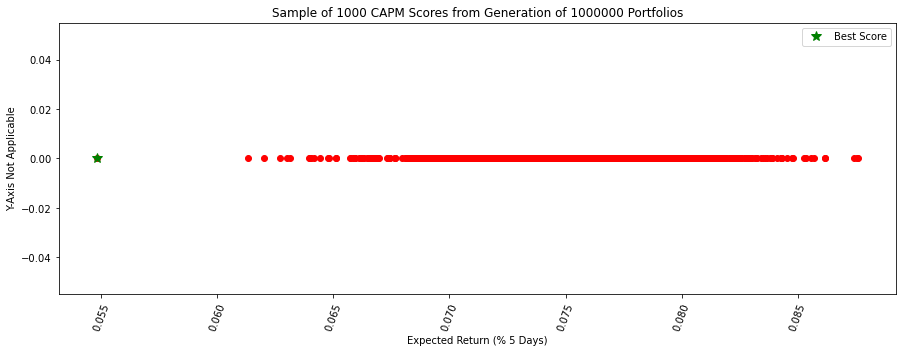

In [33]:
#Must be less than num_hypothetical_portfolios (recommended to be less than 10 000 also).
num_data_points = 1000

frequency = f"{numdays} Days"

#Indexes for Sample of CAPM scores.
index_for_graph = np.random.randint(0, (num_hypothetical_portfolios - 1), num_data_points)

#Initialize list with best score.
capm_examples = [port_expected_return]

#Grab 'num_data_points' data points to graph.
for d in range(num_data_points):
    capm_examples.append(mscapm_scores[index_for_graph[d]] * 100) #* 100 so it is represented as a %.

#We have 1d data, so all y values are 0.
y_values = [0] * (num_data_points + 1)

# Plot the data, pinpoint best score.
plt.scatter(capm_examples, y_values, color = 'r')
plt.plot(port_expected_return, 0, marker = '*', color = 'g', ls = 'none', ms = 10, label = 'Best Score')

# Set axis and title.
plt.title(f'Sample of {num_data_points} CAPM Scores from Generation of {num_hypothetical_portfolios} Portfolios')
plt.xlabel(f'Expected Return (% {frequency})')
plt.xticks(rotation = '70')
plt.ylabel('Y-Axis Not Applicable')

#Change size of graph.
plt.gcf().set_size_inches(15, 5)

plt.legend(loc = 'best')

plt.show()

#### 4.3 Returns Check (With Market Comparison)

Below we can test how the actual returns of our portfolio in a given time period compared to the expected return, as well as the market return.

We are using the market as a benchmark because it is the representation of systematic risk. If we can outperform systematic risk, we consider our portfolio a success.

In [34]:
#Consumes a list of tickers, an amount of capital, a list of weights (for each ticker), and start and end date and outputs a list of the value of the weighted portfolio
#On a daily basis from start to end.
def get_harmonized_df(tickers, capital, weights, start, end):
    portfolio_prices_df = get_closing_df(tickers, start, end)

    #We will scale each price such that the first price of each ticker is 'capital' multiplied by their weight in the portfolio.
    for c in range(0, len(portfolio_prices_df.columns)):
        #We will go column by column.
        column = portfolio_prices_df.iloc[:, c]
        scale = (capital / column[0]) * weights[c]

        #Applying scale.
        for row in range(0, len(column.index)):
            column[row] *= scale

    #Grab a sum of the rows (portfolio value).
    portfolio_prices_df['TOTAL'] = portfolio_prices_df.sum(axis = 1)
    portfolio_prices_df = portfolio_prices_df[['TOTAL']]

    return(portfolio_prices_df)

#Provides the percent change from the first price to the last price of a list of prices.
def get_pct_change(prices):
    #First and last price.
    start = prices[0]
    end = prices[-1]

    #Calculate.
    diff = end - start
    pctchange = diff / start * 100

    return(pctchange)

In [35]:
#It is recommended that 4.3 and 4.4 have dates that line up with the expected return length (e.g one week for 5 days expected return).

#Requires: returnsCheckStart is later than or equal to 'start', returnsCheckEnd is earlier than or equal to 'end', both variables are
#valid trading days, and returnsCheckStart is earlier than returnsCheckEnd.
returnsCheckStart = '2022-11-07'
returnsCheckEnd = '2022-11-11'

#Get prices from start date to end date.
market_prices = get_closing_df([ref_market], returnsCheckStart, returnsCheckEnd)[ref_market].values.tolist()
portfolio_prices = get_harmonized_df(ticklist_final, capital, optimal_weighting, returnsCheckStart, returnsCheckEnd)['TOTAL'].values.tolist()

#Get returns.
market_return = get_pct_change(market_prices)
port_return = get_pct_change(portfolio_prices)

#Summary.
print(f"Return of portfolio from {returnsCheckStart} to {returnsCheckEnd}: {np.round(port_return, 2)}%.")
print(f"Expected return for time period \"{frequency}\" for reference: {np.round(port_expected_return, 2)}%.")
print(f"Return of market \"{market_name}\" during this time period for reference: {np.round(market_return, 2)}%.")

Return of portfolio from 2022-11-07 to 2022-11-11: 0.62%.
Expected return for time period "5 Days" for reference: 0.05%.
Return of market "NYSE" during this time period for reference: 3.67%.


#### 4.4 Graphed Returns Check With Additional Data (With Market Comparison)

Below is an expanded version of the above performance check which can be used to view the performance of the portfolio over specified intervals of time.

The graph shows the returns of the portfolio, the returns of the market, the average return of both, and the expected return of the portfolio.

Then, the average distance from a 0% return of the market and the portfolio, the percentage of returns in the portfolio closer to 0 than the market, the standard deviation of portfolio returns, and the beta of our portfolio is stated.*
    
We use this information to assess our portfolio. Specifically, 6 main characteristics should be present:
     
1. The average return of the portfolio (red line) should be close to the expected return of the portfolio (red dotted line).
2. The average and expected return of the portfolio should be closer to 0 (blue dotted / dashed line) than the market average return (green line).
3. The average distance from 0% return of our portfolio should be smaller than that of the market.
4. There should be a greater percentage of data points from the returns of our portfolio closer to 0 than from the returns of the market.
5. The standard deviation of portfolio returns should be relatively low.
6. The beta value of the portfolio should be less than 1, and greater than -1.

If all of these characteristics are present, we consider the portfolio a success, as this would indicate we have made a good prediction of expected return, beat the market (our benchmark) in terms of our goal, and have a portfolio that is likely to meet our goal if run over a given time period.

* The overall return of the market and portfolio over the time period is available to be viewed as well, if they are un-commented. Please read the explanation above that code before un-commenting.

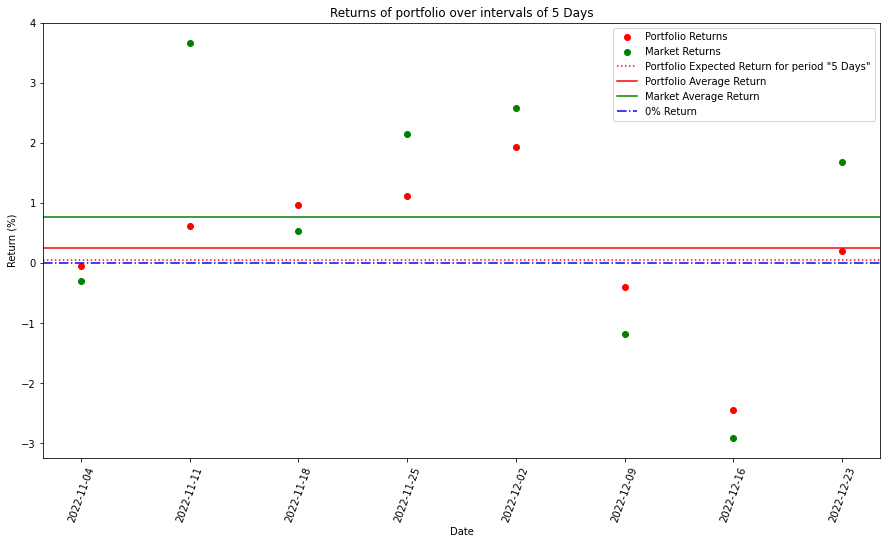

Absolute average distance from 0% return; portfolio: 0.97%
Absolute average distance from 0% return; NYSE: 1.88%

% of weekly returns in portfolio closer to 0 than NYSE: 87.5%

Standard deviation of portfolio returns: 1.23%
Beta of portfolio relative to NYSE: 0.5


In [36]:
startD_strt = '2022-10-31'#Must be a Monday.
endD_strt = '2022-11-04'#Must be a Friday.
weeksPerPeriod = 1

#Initialize sets for Mondays and Fridays.
start_dSet = [startD_strt]
end_dSet = [endD_strt]

#We want 'num_periods' 'weeksPerPeriod' week periods.
num_periods = 8

#Add (num_periods - 1) subsequent (weeksPerPeriod) weeks to start and end sets.
for i in range (0, num_periods - 1):
    start_dSet.append(str((pd.to_datetime(start_dSet[i]) + relativedelta(days = weeksPerPeriod * 7)).strftime("%Y-%m-%d")))
    end_dSet.append(str((pd.to_datetime(end_dSet[i]) + relativedelta(days = weeksPerPeriod * 7)).strftime("%Y-%m-%d")))


#start_dSet = [date_to_replace_with if item == date_to_replace else item for item in start_dSet] #If there is a monday in your start date set which is a holiday, replace it with the tuesday here.
#end_dSet = [date_to_replace_with if item == date_to_replace else item for item in end_dSet] #If there is a friday in your end date set which is a holiday, replace it with thursday here.

#Initialize list of returns for graph.
market_returns = []
port_returns = []

#Grab price information across all dates (DataFrame).
marketPrices2 = get_closing_df([ref_market], start_dSet[0], end_dSet[-1])
portfolioPrices2 = get_harmonized_df(ticklist_final, capital, optimal_weighting, start_dSet[0], end_dSet[-1])

#Grab the returns for each period specified by the user, add to list.
for d in range(0, len(start_dSet)):
    #Basically grabbing price data in between two dates from the DataFrame, and converting those values to a list, then getting the pct change.
    marketPrices2Sub = marketPrices2.loc[start_dSet[d]:end_dSet[d], ref_market].values.tolist()
    market_returns.append(get_pct_change(marketPrices2Sub))

    portfolioPrices2Sub = portfolioPrices2.loc[start_dSet[d]:end_dSet[d], 'TOTAL'].values.tolist()
    port_returns.append(get_pct_change(portfolioPrices2Sub))

#Grab price information across all dates (list).
marketPricesWhole = marketPrices2[ref_market].values.tolist()
portfolioPricesWhole = portfolioPrices2['TOTAL'].values.tolist()

#Get percent change across all dates.
market_pctchange = get_pct_change(market_prices)
portfolio_pctchange = get_pct_change(portfolio_prices)

# Plot the data, set reference lines for portfolio expected return, actual return, market return, 0.
plt.scatter(end_dSet, port_returns, color = 'r', label = 'Portfolio Returns')
plt.scatter(end_dSet, market_returns, color = 'g', label = 'Market Returns')
plt.axhline(y = port_expected_return, color = 'r', linestyle = ':', label = f'Portfolio Expected Return for period \"{frequency}\"')
plt.axhline(y = np.mean(port_returns), color = 'r', linestyle = '-', label = 'Portfolio Average Return')
plt.axhline(y = np.mean(market_returns), color = 'g', linestyle = '-', label = 'Market Average Return')
#These two do not compare well with some of the reference points provided above, and should only be used for fun.
#These show the real returns of the profile, over a term likely much longer than what the user chose.
#plt.axhline(y = portfolio_pctchange, color = 'r', linestyle = '-', label = 'Portfolio Return')
#plt.axhline(y = market_pctchange, color = 'g', linestyle = '-', label = 'Market Return')
plt.axhline(y = 0, color = 'b', linestyle = '-.', label = '0% Return')

# Set axis and title.
plt.title(f'Returns of portfolio over intervals of {frequency}')
plt.xlabel(f'Date')
plt.xticks(rotation = '70')
plt.ylabel(f'Return (%)')

plt.legend(loc = 'best')

#Change size of graph.
plt.gcf().set_size_inches(15, 8)

plt.show()

#Grab average distance from 0 of data points.
returns_abs = [abs(x) for x in port_returns]
market_returns_abs = [abs(x) for x in market_returns]
returnsADF0 = np.round(np.mean(returns_abs), 2)
market_returnsADF0 = np.round(np.mean(market_returns_abs), 2)

closer = 0

#Calculating amount of times our portfolio is closer to 0% return than the market.
for i in range(0, len(returns_abs)):
    if returns_abs[i] < market_returns_abs[i]:
        closer += 1

closer = np.round(closer / len(returns_abs) * 100, 2)

#DataFrame to store the percent returns of the portfolio and market.
portfolio_market_stock_pr_df = pd.DataFrame({"Portfolio": port_returns, "Market Stock": market_returns})
#Beta Calculations of the final portfolio and the market stock.
market_stock_var = portfolio_market_stock_pr_df["Market Stock"].var()
final_portfolio_beta_matrix = portfolio_market_stock_pr_df.cov()/market_stock_var
final_portfolio_beta = final_portfolio_beta_matrix.iloc[0,1]

#Conclusion
print(f"Absolute average distance from 0% return; portfolio: {returnsADF0}%")
print(f"Absolute average distance from 0% return; {market_name}: {market_returnsADF0}%")
print(f"\n% of weekly returns in portfolio closer to 0 than {market_name}: {closer}%")
print(f"\nStandard deviation of portfolio returns: {np.round(np.std(port_returns), 2)}%")
print(f"Beta of portfolio relative to {market_name}: {np.round(final_portfolio_beta, 2)}")

#### 5.1 Output Final Information to .CSV File

In [37]:
#Final DataFrame, output to csv.
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']]
Stocks_Final.to_csv("Stocks.csv", encoding='utf-8')

#### 5.2 Conclusion

Our goal was to take in a list of stocks and generate a portfolio that will yield a short-term return as close to 0% as possible. We first cleaned up our data to ensure each ticker we would use represented a stock who met certain criteria. Then, we chose the best stocks to use, considering volatility and correlation. We generated one million hypothetical portfolios, and used a Multi-Security Capital Asset Pricing Model to obtain the portfolio whose expected return was the closest to zero after a user-selected number of days. Finally, we performed some data analysis, and explained why the portfolio that our code generated is optimal for achieving our goal.

There were many ways to create a portfolio which would fulfill our goals, but we hypothesize that our method (apart from noted drawbacks) is the most efficient and accurate.

#### 5.3 Sources
- Various Code and Concepts: Notes of Professor James Thompson
- *Weight Generation: https://stackoverflow.com/questions/74527506/creating-a-list-of-n-numbers-between-x-and-y-who-sum-up-to-z
- Capital Asset Pricing Model: https://www.investopedia.com/terms/c/capm.asp#toc-the-capm-and-the-efficient-frontier
- Robot Image: http://www.onlinewebfonts.com
- #Combining scores and sorting: https://stackoverflow.com/questions/74891387/combining-elements-of-two-lists-based-on-the-indexes-of-two-separate-lists-in-py